# Multiclass Classification

_

## Environment and data

_

In [1]:
# Standard library imports
import random

# Related third party imports
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN

from nnlibs.embedding.models import Embedding
from nnlibs.convolution.models import Convolution
from nnlibs.pooling.models import Pooling
from nnlibs.flatten.models import Flatten
from nnlibs.dropout.models import Dropout
from nnlibs.dense.models import Dense
from prepare_dataset import prepare_dataset
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)
np.random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
X_features, Y_label = prepare_dataset(N_SAMPLES=7500)

_

## Feed-Forward (FF)

_

### Embedding

_

In [2]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=500,
                      relative_size=(2, 1, 0))

_

### Multi-layers with Dropout

_

In [3]:
name = 'Flatten_Dropout-08_Dense-64-relu_Dropout-07_Dense-10-softmax'

se_hPars['learning_rate'] = 0.05
se_hPars['softmax_temperature'] = 5

flatten = Flatten()

dropout1 = Dropout(keep_prob=0.8)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(keep_prob=0.7)

dense = Dense(10, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

_

In [4]:
model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy())

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dropout
compute_shapes: Dropout
initialize_parameters: Dropout
forward: Dropout
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dropout
compute_shapes: Dropout
initialize_parameters: Dropout
forward: Dropout
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Dropout
backward: Dropout
compute_gradients: Dropout
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Dropout
backward: Dropout
compute_gradients: Dropout
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [5]:
model.train(epochs=100, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  CCE  |                               Experiment                                |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                         |
+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------------------------------------+
|   0   | 5.00e-02 | 5.00e-02 | 0.643 |  0.624   | 0.117 | 0.120 | 1628628279_Flatten_Dropout-08_Dense-64-relu_Dropout-07_Dense-10-softmax |
|  10   | 5.00e-02 | 5.00e-02 | 0.878 |  0.865   | 0.043 | 0.044 | 1628628279_Flatten_Dropout-08_Dense-64-relu_Dropout-07_Dense-10-softmax |
|  20   | 5.00e-02 | 5.00e-02 | 0.904 |  0.890   | 0.035 | 0.037 | 1628628279_Flatten_Dropout-08_Dense-64-relu_Dropout-07_Dense-10-softmax |
|  30   | 5.0

_

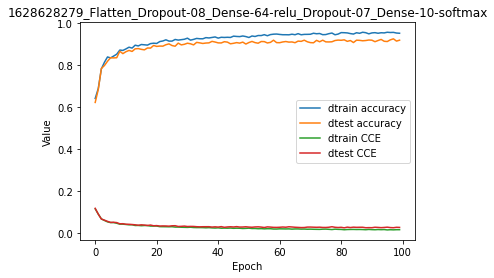

In [6]:
model.plot(path=False)

### _

_

_

_

_

## Convolutional Neural Network (CNN)

_

### Embedding

_

In [7]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=500,
                      relative_size=(2, 1, 0))

_

### Conv-MaxPool-Flatten-Dense

_

In [8]:
name = 'Convolution-32-2_Pooling-3-3-Max_Flatten_Dense-10-softmax'

se_hPars['learning_rate'] = 0.005
se_hPars['softmax_temperature'] = 5

convolution = Convolution(n_filters=32, f_width=2, activate=relu)

pooling = Pooling(pool_size=(3, 3), stride=3)

flatten = Flatten()

# hidden_dense = Dense(128, relu)
dense = Dense(10, softmax)

layers = [embedding, convolution, pooling, flatten, dense]
# layers = [embedding, convolution, pooling, flatten, hidden_dense, dense]

_

In [9]:
model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy())

--- EpyNN Check --- 
Layer: Embedding
compute_shapes: Embedding
initialize_parameters: Embedding
forward: Embedding
Layer: Flatten
compute_shapes: Flatten
initialize_parameters: Flatten
forward: Flatten
Layer: Dropout
compute_shapes: Dropout
initialize_parameters: Dropout
forward: Dropout
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dropout
compute_shapes: Dropout
initialize_parameters: Dropout
forward: Dropout
Layer: Dense
compute_shapes: Dense
initialize_parameters: Dense
forward: Dense
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Dropout
backward: Dropout
compute_gradients: Dropout
Layer: Dense
backward: Dense
compute_gradients: Dense
Layer: Dropout
backward: Dropout
compute_gradients: Dropout
Layer: Flatten
backward: Flatten
compute_gradients: Flatten
Layer: Embedding
backward: Embedding
compute_gradients: Embedding


_

In [10]:
model.train(epochs=30, init_logs=False)

+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  CCE  |                               Experiment                                |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                         |
+-------+----------+----------+-------+----------+-------+-------+-------------------------------------------------------------------------+
|   0   | 5.00e-02 | 5.00e-02 | 0.643 |  0.624   | 0.117 | 0.120 | 1628628279_Flatten_Dropout-08_Dense-64-relu_Dropout-07_Dense-10-softmax |
|   3   | 5.00e-02 | 5.00e-02 | 0.815 |  0.799   | 0.062 | 0.063 | 1628628279_Flatten_Dropout-08_Dense-64-relu_Dropout-07_Dense-10-softmax |
|   6   | 5.00e-02 | 5.00e-02 | 0.844 |  0.836   | 0.052 | 0.053 | 1628628279_Flatten_Dropout-08_Dense-64-relu_Dropout-07_Dense-10-softmax |
|   9   | 5.0

_

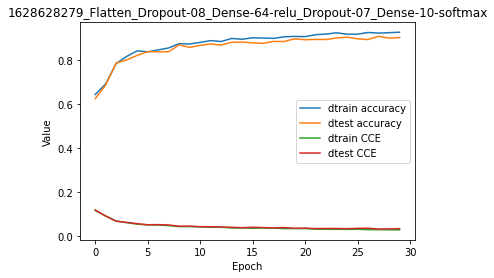

In [11]:
model.plot(path=False)

_

### _

_

_

_

_

_